In [1]:
#Magic command
%matplotlib ipympl
# Some basic imports that are useful
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

#Morphing function
def morph(x1, y1, x2, y2, alpha): 
    xm = alpha * x1 + (1-alpha) * x2 
    ym = alpha * y1 + (1-alpha) * y2
    return xm, ym

# Method 1
* Using points on the side to interpolate and do morphing
* The logic is to first make a set of points that when ploted forms a polygon the point ssghould present on all the sides and then appy morphing on each and every point
* Thus for this to work the total number of point sto form all the polygons should be same and they all should in cyclic or anti-cyclic order
* First I find the verticies and then sort them in the increasing order of the angle they make with the origin
* To do so I find the center of the polygon and find the angle with the help of slope between point and center
* I sort them according to indicies and return the points in cyclic order

In [2]:
# A function with two arguments n,m when n is the number of sides and m is the total number of points in the sides
def generate_polygon(n, m):
    num_vertices = n
    num_points = m

    angles = np.linspace(0, 2*np.pi, num_vertices+1, endpoint=True)
#   Using sines and cosines to calculate the location of verticies sin^2 + cos^2 = 1
    x = 0.5 * np.cos(angles[:-1]) + 0.5
    y = 0.5 * np.sin(angles[:-1]) + 0.5

# Addind the point into sides
    points = np.zeros((num_points, 2))
    for i in range(num_vertices):
        start = i * (num_points // num_vertices)
        end = (i + 1) * (num_points // num_vertices)
#       Addind points between two verticies or a side
        points[start:end, 0] = np.linspace(x[i], x[(i+1)%num_vertices], num_points // num_vertices, endpoint=False)
        points[start:end, 1] = np.linspace(y[i], y[(i+1)%num_vertices], num_points // num_vertices, endpoint=False)

# Sorting the points in the clockwise order so that the plot only has boundary
    # Sort the points in clockwise order
    # Findng the ceneter of the sides, then sorting the points in the order of then tangents.
    centroid = np.mean(points, axis=0)
    
    # Sorting a point according to the angle they make w.r.t to cenetre
    points_angles = np.arctan2(points[:,1] - centroid[1], points[:,0] - centroid[0])
    sorted_indices = np.argsort(points_angles)
    polygon = points[sorted_indices]
    
    return polygon

In [3]:
# Getting the codrdinates of polygon
tri = generate_polygon(3, 840)
sqr = generate_polygon(4, 840)
pen = generate_polygon(5, 840)
hexx = generate_polygon(6, 840)
sept = generate_polygon(7, 840)
octa = generate_polygon(8, 840)

xt,yt = tri[:,0],tri[:,1]
xs,ys = sqr[:,0],sqr[:,1]
xp,yp = pen[:,0],pen[:,1]
xh,yh = hexx[:,0],hexx[:,1]
xse,yse = sept[:,0],sept[:,1]
xo,yo = octa[:,0],octa[:,1]

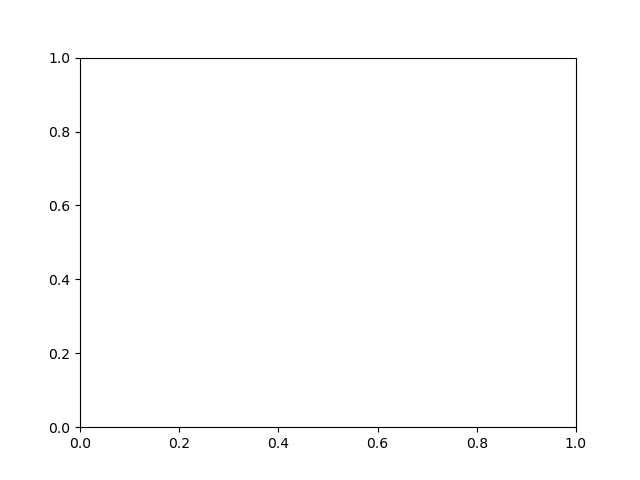

In [4]:
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = ax.plot([], [],'r')


def init(): 
    ax.set_xlim([0, 1]) 
    ax.set_ylim([0,1]) 
    return ln,
'''
Giving  each polygon a time of 0.2 out of 2 sec to be morphed in the animation and multiplying the frame by 5
so that scale for t is 0 to 1 instead of 0 to 0.5

Subracting time elapsed from frames because for next polygon to morph; the t is 0 for polygon but for animation some
time is already elapsed so subracting the elapsed time

From t = 0 to 1 it morphs in acending order of the sides and for  t = 1 to 2 it morphs in decending order of sides

'''
def update(frame):
    if 0 <= frame < 0.2:
        # Morph from triangle to square
        t = (frame)*5
        xdata, ydata = morph(xs, ys, xt, yt, t)
    elif 0.2 <= frame < 0.4:
        # Morph from square to pentagon
        t = (frame-0.2)*5
        xdata, ydata = morph(xp, yp, xs, ys, t)
    elif 0.4 <= frame < 0.6:
        # Morph from pentagon to hexagon
        t = (frame-0.4)*5
        xdata, ydata = morph(xh, yh, xp, yp, t)
    elif 0.6 <= frame < 0.8:
        # Morph from hexagon to septagon
        t = (frame-0.6)*5
        xdata, ydata = morph(xse, yse, xh, yh, t)
    elif 0.8 <= frame < 1.0:
        # Morph from septagon to octagon
        t = (frame-0.8)*5
        xdata, ydata = morph(xo, yo, xse, yse, t)
    elif 1.0 <= frame < 1.2:
        # Morph from octagon to septagon
        t = (frame-1.0)*5
        xdata, ydata = morph(xse, yse, xo, yo, t)
    elif 1.2 <= frame < 1.4:
        # Morph from septagon to hexagon
        t = (frame-1.2)*5
        xdata, ydata = morph(xh, yh, xse, yse, t)
    elif 1.4 <= frame < 1.6:
        # Morph from hexagon to pentagon
        t = (frame-1.4)*5
        xdata, ydata = morph(xp, yp, xh, yh, t)
    elif 1.6 <= frame < 1.8:
        # Morph from pentagon to square
        t = (frame-1.6)*5
        xdata, ydata = morph(xs, ys, xp, yp, t)
    else:
        # Morph from square to triangle
        t = (frame-1.8)*5
        xdata, ydata = morph(xt, yt, xs, ys, t)
    ln.set_data(xdata, ydata)
    return ln,



anim = FuncAnimation(fig, update, frames=np.linspace(0, 2, 500), blit=True,interval=10,repeat=True)

ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

# Method 2 
* Vertices splitting method
* The logic is that the verticies of previous polygon split into the verticies of the new polygon,
* To do so I split the verticies of polygon1 and morph it to the adjacent verticies of polygon2
* Splitter function returns the two vertices of polygon2 to which the verticies of polygon1 has to reach or morph
* Repeater function just repeats the verticies of polygon1 so that length of arrays are same in the morphing function

In [5]:
# Some functions
#  A function that return the cordinates of n-sided polygon
def create_polygon(n):
    # Calculate the vertices of the polygon
    angle = 2 * np.pi / n
    verticesx = [np.cos(i * angle) for i in range(n)]
    verticesy = [np.sin(j * angle) for j in range(n)]
    return np.append(verticesx,verticesx[0]),np.append(verticesy,verticesy[0])

# This function returns a array like [1 1 2 2 3 3] from [1 2 3]
def repeater(arr):
    re = []
    for i in range(len(arr)):
        re = np.append(re,arr[i])
        re = np.append(re,arr[i])
        
    return re[:-1]
  
#  This function returns a array like [1 2 2 3 4] from [1 2 3 4]  
def splitter(arr):
    sp = []
    for i in range(len(arr)-2):
        sp = np.append(sp,arr[i])
        sp = np.append(sp,arr[i+1])
        
    sp = np.append(sp,arr[-1])
    
    return sp

In [6]:
# Polygons
xs2,ys2 = create_polygon(4)
xt2,yt2 = create_polygon(3)
xp2,yp2 = create_polygon(5)
xh2,yh2 = create_polygon(6)
xse2,yse2 = create_polygon(7)
xo2,yo2 = create_polygon(8)

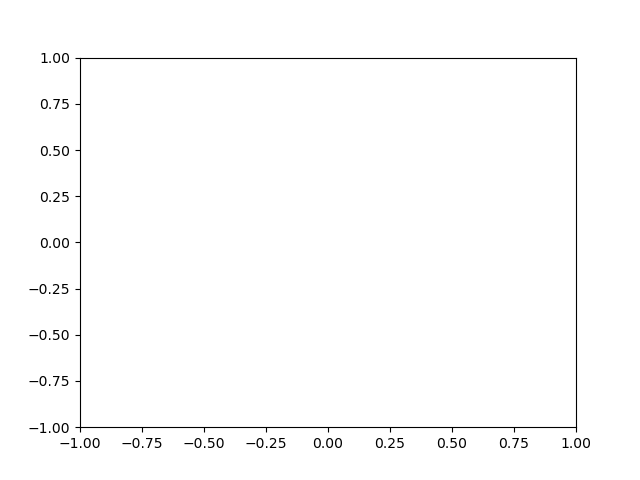

In [7]:
fig2, ax2 = plt.subplots()
xdata, ydata = [], []
ln2, = ax2.plot([], [],'r')


def init2(): 
    ax2.set_xlim([0, 1]) 
    ax2.set_ylim([0,1]) 
    return ln2,

'''
Giving  each polygon a time of 0.2 out of 2 sec to be morphed in the animation and multiplying the frame by 5
so that scale for t is 0 to 1 instead of 0 to 0.5

Subracting time elapsed from frames because for next polygon to morph the t is 0 for polygon but for animation some
time is already elapsed so subracting it

From t = 0 to 1 it morphs in acending order of the sides and for  t = 1 to 2 it morphs in decending order of sides

This time morphing is done on the verticies instead of sides

'''
def animate(frame):
    if 0 <= frame < 0.2:
        # Morph from triangle to square
        xtt,ytt = repeater(xt2),repeater(yt2)
        xss,yss = splitter(xs2),splitter(ys2)
        
        t = (frame)*5
        xdata, ydata = morph(xss, yss, xtt, ytt, t)
    elif 0.2 <= frame < 0.4:
        # Morph from square to pentagon
        xss,yss = repeater(xs2),repeater(ys2)
        xpp,ypp = splitter(xp2),splitter(yp2)
        
        t = (frame-0.2)*5
        xdata, ydata = morph(xpp, ypp, xss, yss, t)
    elif 0.4 <= frame < 0.6:
        # Morph from pentagon to hexagon
        xpp,ypp = repeater(xp2),repeater(yp2)
        xhh,yhh = splitter(xh2),splitter(yh2)
        
        t = (frame-0.4)*5
        xdata, ydata = morph(xhh, yhh, xpp, ypp, t)
    elif 0.6 <= frame < 0.8:
        # Morph from hexagon to septagon
        xhh,yhh = repeater(xh2),repeater(yh2)
        xsese,ysese = splitter(xse2),splitter(yse2)
        
        t = (frame-0.6)*5
        xdata, ydata = morph(xsese, ysese, xhh, yhh, t)
    elif 0.8 <= frame < 1.0:
        # Morph from septagon to octagon
        xsese,ysese = repeater(xse2),repeater(yse2)
        xoo,yoo = splitter(xo2),splitter(yo2)
        
        t = (frame-0.8)*5
        xdata, ydata = morph(xoo, yoo, xsese, ysese, t)
    elif 1.0 <= frame < 1.2:
        # Morph from octagon to septagon
        xsese,ysese = repeater(xse2),repeater(yse2)
        xoo,yoo = splitter(xo2),splitter(yo2)
        
        t = (frame-1.0)*5
        xdata, ydata = morph(xsese, ysese, xoo, yoo, t)
    elif 1.2 <= frame < 1.4:
        # Morph from septagon to hexagon
        xhh,yhh = repeater(xh2),repeater(yh2)
        xsese,ysese = splitter(xse2),splitter(yse2)
        
        t = (frame-1.2)*5
        xdata, ydata = morph(xhh, yhh, xsese, ysese, t)
    elif 1.4 <= frame < 1.6:
        # Morph from hexagon to pentagon
        xpp,ypp = repeater(xp2),repeater(yp2)
        xhh,yhh = splitter(xh2),splitter(yh2)
        
        t = (frame-1.4)*5
        xdata, ydata = morph(xpp, ypp, xhh, yhh, t)
    elif 1.6 <= frame < 1.8:
        # Morph from pentagon to square
        xss,yss = repeater(xs2),repeater(ys2)
        xpp,ypp = splitter(xp2),splitter(yp2)
        
        t = (frame-1.6)*5
        xdata, ydata = morph(xss, yss, xpp, ypp, t)
    else:
        # Morph from square to triangle
        xtt,ytt = repeater(xt2),repeater(yt2)
        xss,yss = splitter(xs2),splitter(ys2)
        t = (frame-1.8)*5
        xdata, ydata = morph(xtt, ytt, xss, yss, t)
        
    ln2.set_data(xdata, ydata)
    return ln2,


ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])

anim = FuncAnimation(fig2, animate, frames=np.linspace(0, 2, 500), blit=True,interval=10,repeat=True)
plt.show()

<div class="alert alert-block alert-danger">Restart the notebook after this other wise the global naming may give problems to both the animation, if you run the 1st animation once more or first and second once more after this without resetting, in the some order the animation may get disturb, this may or maynot happend but should kept in mind,if the animation are glitiching or abrupt please restart and run all in the kernel menu, also while exiting the notebook shutdown the kernel</div>